In [1]:
import time
start = time.time()

In [2]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications
import pprint
from Constants import *
%matplotlib inline

c:\Users\dell\miniconda3\envs\tf_cpu\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [3]:
tf.random.set_seed(272)
pp = pprint.PrettyPrinter(indent = 4)
image_size = 400
vgg = applications.VGG19(include_top = False,
                         input_shape = (image_size, image_size, 3),
                         weights = 'pretrained_model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
                         )
vgg.trainable = False
pp.pprint(vgg)

The content image is the Louvre museum's pyramid


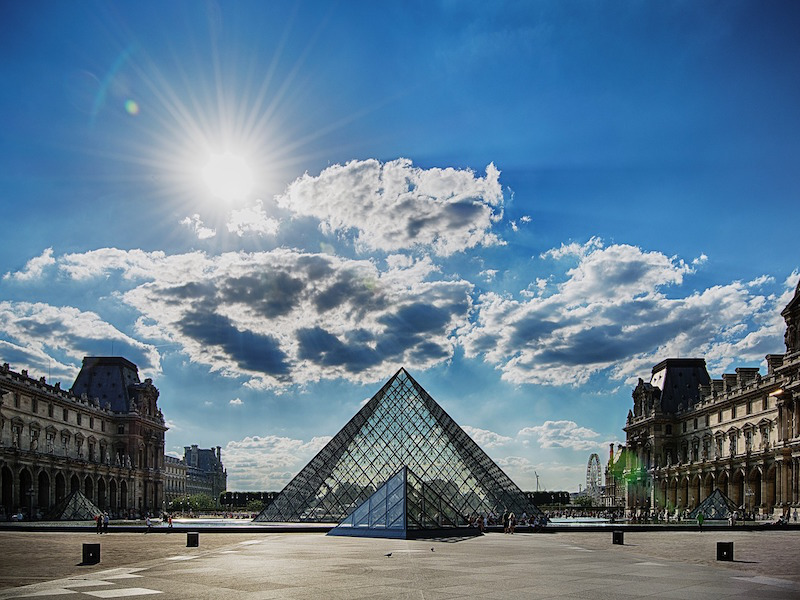

In [4]:
content_image = Image.open("images/louvre.jpg")
print("The content image is the Louvre museum's pyramid")
content_image

In [5]:
def compute_content_cost(content_output, generated_output):
    
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_C_unrolled = tf.reshape(a_C, shape = [m, n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape = [m, n_H * n_W, n_C])
    
    J_content = tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled)) / (4.0 * n_H * n_W * n_C)
    
    return J_content

In [6]:
content_cost(compute_content_cost)

J_content = tf.Tensor(7.056877, shape=(), dtype=float32)


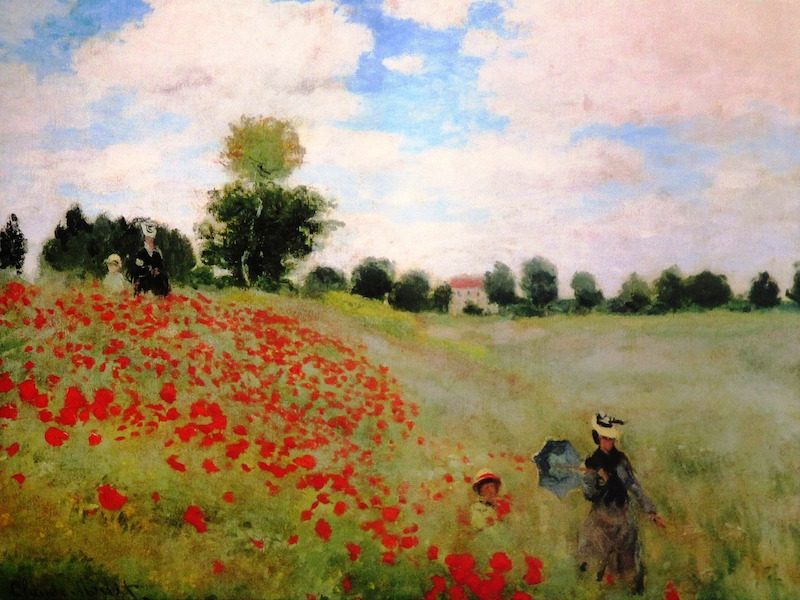

In [7]:
style_image = Image.open("images/monet_800600.jpg")
style_image

In [8]:
def style_matrix(A):
    
    style_mat_A = tf.matmul(A, tf.transpose(A))
    
    return style_mat_A

In [9]:
style_mat(style_matrix)

GA = 
tf.Tensor(
[[ 63.1888    -26.721275   -7.7320204]
 [-26.721275   12.76758    -2.5158243]
 [ -7.7320204  -2.5158243  23.752384 ]], shape=(3, 3), dtype=float32)


In [10]:
def compute_layer_style_cost(a_S, a_G):
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S, shape = [-1, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape = [-1, n_C]))
    
    style_mat_S = style_matrix(a_S)
    style_mat_G = style_matrix(a_G)
    
    J_style_layer = tf.reduce_sum(tf.square(style_mat_S - style_mat_G)) / (4.0 * ((n_H * n_W * n_C) ** 2))
    
    return J_style_layer

In [11]:
layer_style_cost(compute_layer_style_cost)

J_style_layer = tf.Tensor(14.017808, shape=(), dtype=float32)


In [12]:
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [13]:
vgg.get_layer('block5_conv4').output

<KerasTensor: shape=(None, 25, 25, 512) dtype=float32 (created by layer 'block5_conv4')>

In [14]:
# Layers to be used for style image, this can be redefined

STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2),
]

In [15]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS = STYLE_LAYERS):
    
    J_style = 0
    
    a_S = style_image_output[:-1]
    a_G = generated_image_output[:-1]
    
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])
        J_style += weight[1] * J_style_layer
        
    return J_style

In [16]:
#@tf.function
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    
    J = alpha * J_content + beta * J_style
    
    return J

In [17]:
total_costs(total_cost)

J = 32.98319978471206


(1, 400, 400, 3)


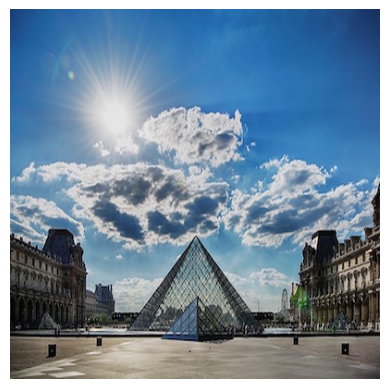

In [18]:
content_image = np.array(Image.open("images/louvre_small.jpg").resize((image_size, image_size)))
content_image = tf.constant(np.reshape(content_image, ((1, ) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.axis("off")
plt.show()

(1, 400, 400, 3)


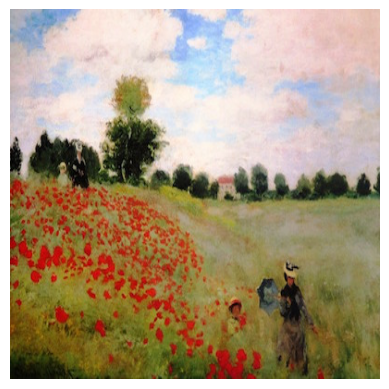

In [19]:
style_image = np.array(Image.open("images/monet.jpg").resize((image_size, image_size)))
style_image = tf.constant(np.reshape(style_image, ((1, ) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.axis("off")
plt.show()

(1, 400, 400, 3)


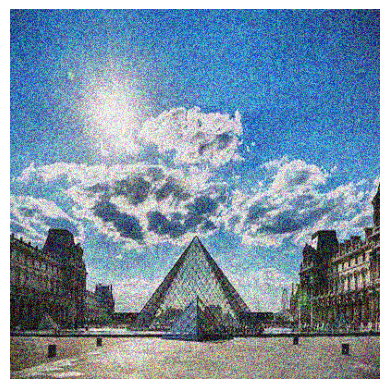

In [20]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.35)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min = 0.0, clip_value_max = 1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.axis("off")
plt.show()

In [21]:
def get_layer_outputs(vgg, layer_names):
    
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    
    return model

In [22]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [23]:
content_target = vgg_model_outputs(content_image)

style_targets = vgg_model_outputs(style_image)

In [24]:
preprocessed_content = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

In [25]:
preprocessed_style = tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [26]:
def truncate_pixels(image):
    
    return tf.clip_by_value(image, clip_value_min = 0.0, clip_value_max = 1.0)


def tensor_to_image(tensor):
    
    tensor = tensor * 255
    tensor = np.array(tensor, dtype = np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
        
    return Image.fromarray(tensor)

In [27]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 0.01)

#@tf.function()
def train_step(generated_image, alpha = 10, beta = 40):
    
    with tf.GradientTape() as tape:
        
        a_G = vgg_model_outputs(generated_image)
        
        J_style = compute_style_cost(a_S, a_G)
        J_content = compute_content_cost(a_C, a_G)
        
        J = total_cost(J_content, J_style, alpha = alpha, beta = beta)
        
    grad = tape.gradient(J, generated_image)
    
    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(truncate_pixels(generated_image))
    
    return J

generated_image = tf.Variable(generated_image)

In [28]:
train_steps(train_step, generated_image)

tf.Tensor(34888.363, shape=(), dtype=float32)
tf.Tensor(25020.115, shape=(), dtype=float32)


Epoch 0 


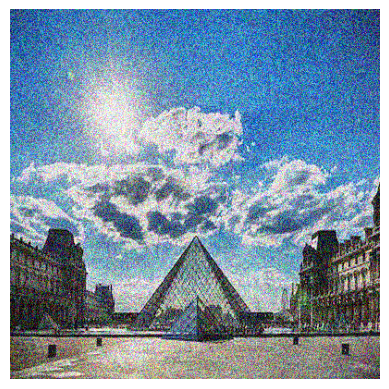

Epoch 50 


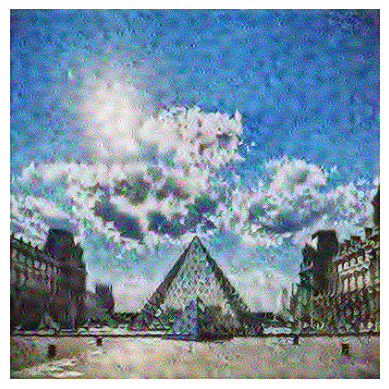

Epoch 100 


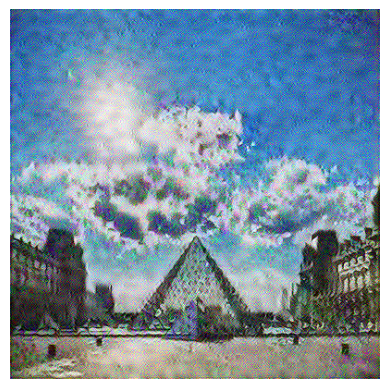

Epoch 150 


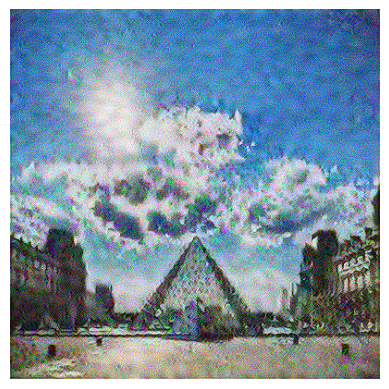

In [29]:
epochs = 200
for i in range(epochs):
    train_step(generated_image)
    if i % 50 == 0:
        print(f"Epoch {i} ")
    if i % 50 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        #image.save(f"output/image_{i}.jpg")
        plt.axis("off")
        plt.show()

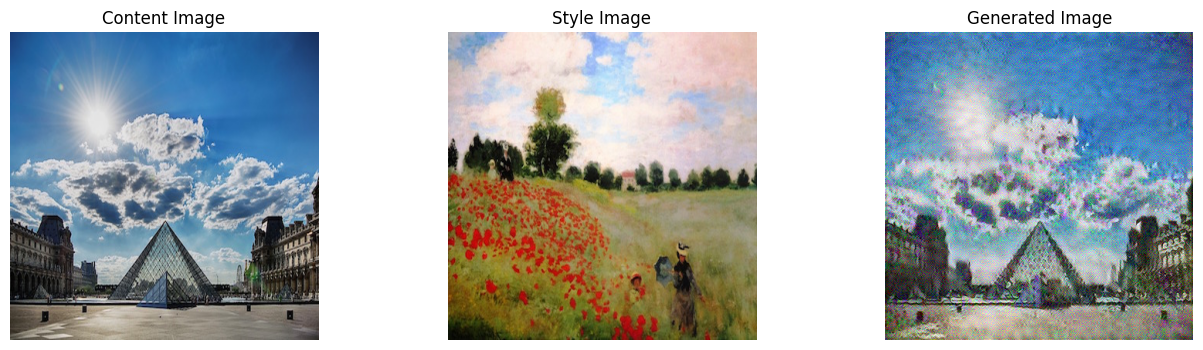

In [30]:
fig = plt.figure(figsize = (16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text("Content Image")
plt.axis("off")
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text("Style Image")
plt.axis("off")
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text("Generated Image")
plt.axis("off")
plt.show()

In [45]:
end = time.time()
total = end - start
print("Total Time elapsed (mins): {:0.2f}".format(total / 60))

Total Time elapsed (mins): 29.87


In [32]:
'''%%javascript
IPython.notebook.save_checkpoint();
if (confirm("Clear memory?") == true)
{
    IPython.notebook.kernel.restart();
}'''

'%%javascript\nIPython.notebook.save_checkpoint();\nif (confirm("Clear memory?") == true)\n{\n    IPython.notebook.kernel.restart();\n}'